# Измерение влияния low rank разложения на время inference слоёв ResNet
Данные представлены помодульно (в основном для conv2d, но присутствует и один DecomposedLinear)

Основные варьируемые характеристики:
- compose_mode: one_layer, two_layers, three_layers
- batch_size: 8, 16 (или по желанию любые)
- threshold: (0, 1]

In [ ]:
from copy import deepcopy
import itertools
import torch

from fedcore.algorithm.low_rank.low_rank_opt import LowRankModel
from fedcore.algorithm.low_rank.rank_pruning import SLRStrategiesEnum, rank_threshold_pruning_in_place
from fedcore.architecture.utils.misc import count_params
from fedcore.models.network_impl.decomposed_layers import IDecomposed
from fedcore.tools.dataload.per_layer_random_dataloader import create_synthetic_dataloader_per_module_shape
from fedcore.tools.ruler import PerformanceEvaluator
import pandas as pd

from fedcore.tools.dataload.small_cifar10_dataloader import get_small_cifar10_train_and_val_loaders
from fedcore.tools.template_fedcore_models import create_low_rank_with_prune_on_0_epoch


train_dataloader, val_dataloader = get_small_cifar10_train_and_val_loaders(batch_size=8, val_size=2000)

def experiment_body_layerwise_without_compose(lowRankModel: LowRankModel, bs=8, thr=0.05, mode=SLRStrategiesEnum._member_names_[0], comp="one_layer", device_str="cpu", num_of_evaluation_repeats = 10, compare_with_decomposed=False):
        
        print(f"Running experiment bs={bs} thr={thr} mode={mode} compose={comp}")
        
        lowRankModel = deepcopy(lowRankModel)

        if (compare_with_decomposed):
            #if we want to compare decomposed & decomposed+compose+pruned
            lowRankModel.model_before = deepcopy(lowRankModel.model_after)
        
        device = torch.device(device_str)

        i = 0
        old_modules = list(lowRankModel.model_before.modules())
        history = []
        for name, module in lowRankModel.model_after.named_modules(): #THIS SECTION IMITATES ONE_TIME_RANK_PRUNER hook
            if isinstance(module, IDecomposed) and len(list(module.children())) == 0: 
                rank_threshold_pruning_in_place(decomposed_module=module, 
                                       threshold=thr,
                                       strategy=mode,
                                       module_name=name)
                
                module.compose_mode = comp
                module.compose_weight_for_inference()
            
                module_before = old_modules[i]
                module_after = module
                # if (module_after.Vh is not None):
                #     print("Vh shape", module_after.Vh.shape)

                synth_dataloader = create_synthetic_dataloader_per_module_shape(module_before, batch_size=bs, n_batches=num_of_evaluation_repeats)

                #send model and data to the device (cpu/cuda)
                eval_before = PerformanceEvaluator(module_before, data=synth_dataloader, batch_size=bs, device=device, n_batches=num_of_evaluation_repeats)
                eval_after = PerformanceEvaluator(module_after, data=synth_dataloader, batch_size=bs, device=device, n_batches=num_of_evaluation_repeats)
                print("eval module_before", module_before._get_name())
                metrics_before = eval_before.eval()
                print("eval module_after", module_after._get_name())
                metrics_after = eval_after.eval()
                #acc_before, acc_after = compare_accuracy(trained_lr)
                history.append({
                    "batch_size": bs,
                    "threshold": thr,
                    "low_rank_mode": mode,
                    "compose_mode": comp,
                    "device": device_str,
                    # before metrics
                    "before_module_name": module_before._get_name(),
                    "before_module_params": count_params(module_before),
                    "before_module_shape": list(module_before.weight.shape) if module_before.weight is not None else None,
                    "before_latency_mean s": metrics_before.get("latency", [None])[0] if isinstance(metrics_before.get("latency"), (list, tuple)) else None,
                    "before_latency_std s": metrics_before.get("latency", [None, None])[1] if isinstance(metrics_before.get("latency"), (list, tuple)) else None,
                    "before_throughput_mean s": metrics_before.get("throughput", [None])[0] if isinstance(metrics_before.get("throughput"), (list, tuple)) else None,
                    "before_throughput_std s": metrics_before.get("throughput", [None, None])[1] if isinstance(metrics_before.get("throughput"), (list, tuple)) else None,
                    "before_model_size_mb": metrics_before.get("model_size", [None])[0] if isinstance(metrics_before.get("model_size"), (list, tuple)) else None,
                    # after metrics
                    "after_module_name": module_after._get_name(),
                    "after_module_params": count_params(module_after),
                    "after_S_params": module_after.S.numel() if module_after.S is not None else 0,
                    "after_Vh_params": module_after.Vh.numel() if module_after.Vh is not None else 0,
                    "after_U_params": module_after.U.numel() if module_after.U is not None else 0,
                    "after_latency_mean s": metrics_after.get("latency", [None])[0] if isinstance(metrics_after.get("latency"), (list, tuple)) else None,
                    "after_latency_std s": metrics_after.get("latency", [None, None])[1] if isinstance(metrics_after.get("latency"), (list, tuple)) else None,
                    "after_throughput_mean s": metrics_after.get("throughput", [None])[0] if isinstance(metrics_after.get("throughput"), (list, tuple)) else None,
                    "after_throughput_std s": metrics_after.get("throughput", [None, None])[1] if isinstance(metrics_after.get("throughput"), (list, tuple)) else None,
                    "after_model_size_mb": metrics_after.get("model_size", [None])[0] if isinstance(metrics_after.get("model_size"), (list, tuple)) else None,
                    "after_S_shape": list(module_after.S.shape) if module_after.S is not None else 0,
                    "after_Vh_shape": list(module_after.Vh.shape) if module_after.Vh is not None else 0,
                    "after_U_shape": list(module_after.U.shape) if module_after.U is not None else 0,
                })
            i += 1

        return history

def full_experiment_layerwise(lowRankModel: LowRankModel, device_str, n_eval=20):
    batch_sizes = [8, 16]#[32, 64] #16, 32]                     # можно расширить до 1..128
    thresholds = [0.0001, 0.1, 0.5, 0.9]#0.1, 0.2, 0.4]
    low_rank_modes = [SLRStrategiesEnum._member_names_[0]]  # при необходимости добавить другие режимы
    compose_modes = ["one_layer", "two_layers", "three_layers"]

    devices = ["cpu"] + (["cuda"] if torch.cuda.is_available() else [])

    rows = []
    all_iterations = len(batch_sizes) * len(thresholds) * len(low_rank_modes) * len(compose_modes)

    # loop over parameter grid
    i = 1
    for bs, thr, mode, comp in itertools.product(batch_sizes, thresholds, low_rank_modes, compose_modes):
        print("STEP:", i, "FROM", all_iterations)
        rows.extend(experiment_body_layerwise_without_compose(lowRankModel, bs, thr, mode, comp, device_str, n_eval))
        print(f"Done device={device_str} bs={bs} thr={thr} comp={comp} mode={mode}")
        i += 1
    return rows


TRAINED_LR, input_data = create_low_rank_with_prune_on_0_epoch(train_dataloader, val_dataloader, epochs=0)
TRAINED_LR.fit(input_data)

c:\myfolder\FedCore\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\myfolder\FedCore\venv\lib\site-packages\hyperopt\atpe.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


2025-11-18 17:47:15,659 - Device <cpu> is selected
2025-11-18 17:47:15,672 - Device <cpu> is selected
2025-11-18 17:47:15,672 - Device <cpu> is selected
Files already downloaded and verified
Files already downloaded and verified
LearningConfig(learning_strategy='from_checkpoint', peft_strategy='low_rank', criterion='cross_entropy', peft_strategy_params=LowRank(log_each=None, eval_each=None, save_each=None, epochs=0, optimizer='adam', scheduler=None, criterion='cross_entropy', custom_learning_params={}, custom_criterions={}, model_architecture=ModelArchitectureConfig(input_dim=None, output_dim=None, depth=3, custom_model_params={}), strategy='quantile', rank_prune_each=-1, compose_mode=None, non_adaptive_threshold=0.5, finetune_params=NeuralModelConfig(log_each=None, eval_each=None, save_each=None, epochs=1, optimizer='adam', scheduler=None, criterion='cross_entropy', custom_learning_params={}, custom_criterions={}, model_architecture=ModelArchitectureConfig(input_dim=None, output_dim=N

ResNet(
  (conv1): DecomposedConv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): DecomposedConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): DecomposedConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): DecomposedConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

In [2]:
#after "fit" - model has all decomposed layers
assert TRAINED_LR.model_after.conv1.U is not None
assert TRAINED_LR.model_after.conv1.S is not None
assert TRAINED_LR.model_after.conv1.Vh is not None
#and it can forward
assert type(TRAINED_LR.model_after.conv1(next(iter(val_dataloader))[0])) == torch.Tensor

In [3]:

from datetime import datetime
#layerwise_experiment_rows = full_experiment_layerwise(TRAINED_LR, "cpu", n_eval=20)

#df = pd.DataFrame(layerwise_experiment_rows)
df = pd.read_csv("low_rank_layerwise_18112025_160022.csv")
# ts = datetime.now().strftime("%d%m%Y_%H%M%S")
# out_csv = f"low_rank_layerwise_{ts}.csv"
# df.to_csv(out_csv, index=False)
# print(f"Saved results to {out_csv}")

In [4]:
df

,batch_size,threshold,low_rank_mode,compose_mode,device,before_module_name,before_module_params,before_module_shape,before_latency_mean s,before_latency_std s,...,after_Vh_params,after_U_params,after_latency_mean s,after_latency_std s,after_throughput_mean s,after_throughput_std s,after_model_size_mb,after_S_shape,after_Vh_shape,after_U_shape
0,8,0.0001,quantile,one_layer,cpu,Conv2d,9408,"[64, 3, 7, 7]",0.000242,0.000167,...,0,9408,0.000118,0.000042,0.000032,0.000011,0.036,0,0,"[64, 3, 7, 7]"
1,8,0.0001,quantile,one_layer,cpu,Conv2d,36864,"[64, 64, 3, 3]",0.000569,0.000292,...,0,36864,0.000350,0.000101,0.000191,0.000042,0.141,0,0,"[64, 64, 3, 3]"
2,8,0.0001,quantile,one_layer,cpu,Conv2d,36864,"[64, 64, 3, 3]",0.000384,0.000124,...,0,36864,0.000338,0.000080,0.000208,0.000015,0.141,0,0,"[64, 64, 3, 3]"
3,8,0.0001,quantile,one_layer,cpu,Conv2d,36864,"[64, 64, 3, 3]",0.000388,0.000085,...,0,36864,0.000381,0.000118,0.000188,0.000030,0.141,0,0,"[64, 64, 3, 3]"
4,8,0.0001,quantile,one_layer,cpu,Conv2d,36864,"[64, 64, 3, 3]",0.000307,0.000058,...,0,36864,0.000348,0.000053,0.000187,0.000015,0.141,0,0,"[64, 64, 3, 3]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499,16,0.9000,quantile,three_layers,cpu,Conv2d,2359296,"[512, 512, 3, 3]",0.013461,0.009195,...,239616,26624,0.001716,0.000208,0.001522,0.000129,1.016,"[52, 1, 1]","[52, 512, 3, 3]","[512, 52, 1, 1]"
500,16,0.9000,quantile,three_layers,cpu,Conv2d,131072,"[512, 256, 1, 1]",0.000373,0.000096,...,7168,14336,0.000528,0.000098,0.000129,0.000015,0.082,"[28, 1, 1]","[28, 256, 1, 1]","[512, 28, 1, 1]"
501,16,0.9000,quantile,three_layers,cpu,Conv2d,2359296,"[512, 512, 3, 3]",0.010864,0.008333,...,239616,26624,0.001703,0.000286,0.001364,0.000145,1.016,"[52, 1, 1]","[52, 512, 3, 3]","[512, 52, 1, 1]"
502,16,0.9000,quantile,three_layers,cpu,Conv2d,2359296,"[512, 512, 3, 3]",0.013597,0.009460,...,239616,26624,0.001753,0.000233,0.001374,0.000106,1.016,"[52, 1, 1]","[52, 512, 3, 3]","[512, 52, 1, 1]"


In [5]:
counter = 0
for name, module in TRAINED_LR.model_after.named_modules(): #THIS SECTION IMITATES ONE_TIME_RANK_PRUNER hook
    if isinstance(module, IDecomposed) and len(list(module.children())) == 0: 
        counter += 1
print(counter)
counter = 0
for name, module in TRAINED_LR.model_after.named_modules(): #THIS SECTION IMITATES ONE_TIME_RANK_PRUNER hook
        counter += 1
print(counter)

21
68


In [6]:
# ...existing code...
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_latency_paired_grouped_5(df, target_characteristic_name="latency"):
    TARGET_CHARACTERISTIC_NAME = target_characteristic_name
    """
    Надёжная версия: для всех трёх фасетов берём mean/std прямо из колонок
    (before_latency_mean s / before_latency_std s / after_latency_mean s / after_latency_std s).
    Сравнения делаем по str-значениям меток, чтобы фасеты всегда заполнялись.
    Ожидает колонки: 'threshold','batch_size','compose_mode',
                     'before_latency_mean s','before_latency_std s',
                     'after_latency_mean s','after_latency_std s'
    """
    df2 = df.copy()
    df2["threshold"] = pd.to_numeric(df2["threshold"], errors="coerce")
    # df2 = df2.replace([np.inf, -np.inf], np.nan).dropna(subset=[
    #     "threshold", "batch_size", "compose_mode",
    #     "before_latency_mean s", "after_latency_mean s",
    #     "before_throughput_mean s", "after_throughput_mean s"
    # ])
    if df2.empty:
        print("Нет валидных данных.")
        return

    def _paired_bars(ax, labels, before_mean, before_std, after_mean, after_std,
                     xlabel=None, ylabel="latency (s)"):
        x = np.arange(len(labels))
        width = 0.35
        before_mean = np.nan_to_num(np.array(before_mean, dtype=float), nan=0.0)
        after_mean = np.nan_to_num(np.array(after_mean, dtype=float), nan=0.0)
        before_std = np.nan_to_num(np.array(before_std, dtype=float), nan=0.0)
        after_std = np.nan_to_num(np.array(after_std, dtype=float), nan=0.0)

        ax.bar(x - width/2, before_mean, width, label="before", color="C0", alpha=0.6)
        ax.bar(x + width/2, after_mean, width, label="after", color="C1", alpha=0.6)

        # точки среднего и усы ±std (берём std из колонок)
        ax.errorbar(x - width/2, before_mean, yerr=before_std, fmt='o', color='black', capsize=4, elinewidth=1.2)
        ax.errorbar(x + width/2, after_mean, yerr=after_std, fmt='o', color='black', capsize=4, elinewidth=1.2)

        ax.set_xticks(x)
        ax.set_xticklabels(labels, rotation=45, ha="right")
        if xlabel:
            ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.legend()

    # helper: берём первую подходящую строку в subset для каждой метки (сравнение по str)
    def _collect_from_subset(subset, group_col, labels):
        before_mean = []
        before_std = []
        after_mean = []
        after_std = []
        if subset.empty:
            for _ in labels:
                before_mean.append(np.nan); before_std.append(np.nan)
                after_mean.append(np.nan); after_std.append(np.nan)
            return (before_mean, before_std, after_mean, after_std)

        col_as_str = subset[group_col].astype(str)
        for lbl in labels:
            mask = (col_as_str == str(lbl))
            if not mask.any():
                before_mean.append(np.nan); before_std.append(np.nan)
                after_mean.append(np.nan); after_std.append(np.nan)
            else:
                r = subset[mask].iloc[0]
                before_mean.append(r.get(f"before_{TARGET_CHARACTERISTIC_NAME}_mean s", np.nan))
                before_std.append(r.get(f"before_{TARGET_CHARACTERISTIC_NAME}_std s", np.nan))
                after_mean.append(r.get(f"after_{TARGET_CHARACTERISTIC_NAME}_mean s", np.nan))
                after_std.append(r.get(f"after_{TARGET_CHARACTERISTIC_NAME}_std s", np.nan))
        return (before_mean, before_std, after_mean, after_std)


    comp_vals = ["one_layer", "two_layers", "three_layers"]
    # 1) compose_mode dependence: facet by threshold (rows) and batch_size (cols)
    thr_vals = sorted(df2["threshold"].unique())
    bs_vals = sorted(df2["batch_size"].unique())
    nrows, ncols = max(1, len(thr_vals)), max(1, len(bs_vals))
    fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 3*nrows), squeeze=False)
    for i, thr in enumerate(thr_vals):
        for j, bs in enumerate(bs_vals):
            ax = axes[i][j]
            subset = df2[(df2["threshold"] == thr) & (df2["batch_size"] == bs)]
            if subset.empty:
                ax.text(0.5, 0.5, "no data", ha="center", va="center")
                ax.set_xticks([]); ax.set_yticks([])
                ax.set_title(f"thr={thr} bs={bs}")
                continue
            labels = comp_vals
            bm, bs_std, am, a_std = _collect_from_subset(subset, "compose_mode", labels)
            _paired_bars(ax, labels, bm, bs_std, am, a_std, xlabel="compose_mode")
            ax.set_title(f"thr={thr}  bs={bs}")
    plt.tight_layout()
    plt.suptitle(f"{TARGET_CHARACTERISTIC_NAME} before/after by compose_mode (faceted by threshold & batch_size)", y=1.02)
    plt.show()

    # 2) batch_size dependence: facet by threshold (rows) and compose_mode (cols), x=batch_size
    thr_vals = sorted(df2["threshold"].unique())
    nrows, ncols = max(1, len(thr_vals)), max(1, len(comp_vals))
    fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 3*nrows), squeeze=False)
    for i, thr in enumerate(thr_vals):
        for j, comp in enumerate(comp_vals):
            ax = axes[i][j]
            # фильтруем по threshold и compose_mode (строковые сравнения для compose_mode)
            subset = df2[(df2["threshold"] == thr) & (df2["compose_mode"].astype(str) == comp)]
            if subset.empty:
                ax.text(0.5, 0.5, "no data", ha="center", va="center")
                ax.set_xticks([]); ax.set_yticks([])
                ax.set_title(f"thr={thr} comp={comp}")
                continue
            # метки batch_size (строками), отсортировать по числовому значению
            labels = sorted(subset["batch_size"].astype(str).unique(), key=lambda x: float(x))
            bm, bs_std, am, a_std = _collect_from_subset(subset, "batch_size", labels)
            _paired_bars(ax, labels, bm, bs_std, am, a_std, xlabel="batch_size")
            ax.set_title(f"thr={thr}  comp={comp}")
    plt.tight_layout()
    plt.suptitle(f"{TARGET_CHARACTERISTIC_NAME} before/after by batch_size (faceted by threshold & compose_mode)", y=1.02)
    plt.show()

    # 3) threshold dependence: facet by batch_size (rows) and compose_mode (cols), x=threshold
    bs_vals = sorted(df2["batch_size"].unique())
    thr_vals_sorted = sorted(df2["threshold"].unique())
    nrows, ncols = max(1, len(bs_vals)), max(1, len(comp_vals))
    fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 3*nrows), squeeze=False)
    for i, bs in enumerate(bs_vals):
        for j, comp in enumerate(comp_vals):
            ax = axes[i][j]
            subset = df2[(df2["batch_size"] == bs) & (df2["compose_mode"].astype(str) == comp)]
            if subset.empty:
                ax.text(0.5, 0.5, "no data", ha="center", va="center")
                ax.set_xticks([]); ax.set_yticks([])
                ax.set_title(f"bs={bs} comp={comp}")
                continue
            # сохранить порядок порогов, но оставить только те, которые встречаются в subset
            available_thr = subset["threshold"].dropna().unique()
            labels = [str(x) for x in thr_vals_sorted if x in available_thr]
            if not labels:
                ax.text(0.5, 0.5, "no data", ha="center", va="center")
                continue
            bm, bs_std, am, a_std = _collect_from_subset(subset, "threshold", labels)
            _paired_bars(ax, labels, bm, bs_std, am, a_std, xlabel="threshold")
            ax.set_title(f"bs={bs}  comp={comp}")
    plt.tight_layout()
    plt.suptitle(f"{TARGET_CHARACTERISTIC_NAME} before/after by threshold (faceted by batch_size & compose_mode)", y=1.02)
    plt.show()

# ...existing code...

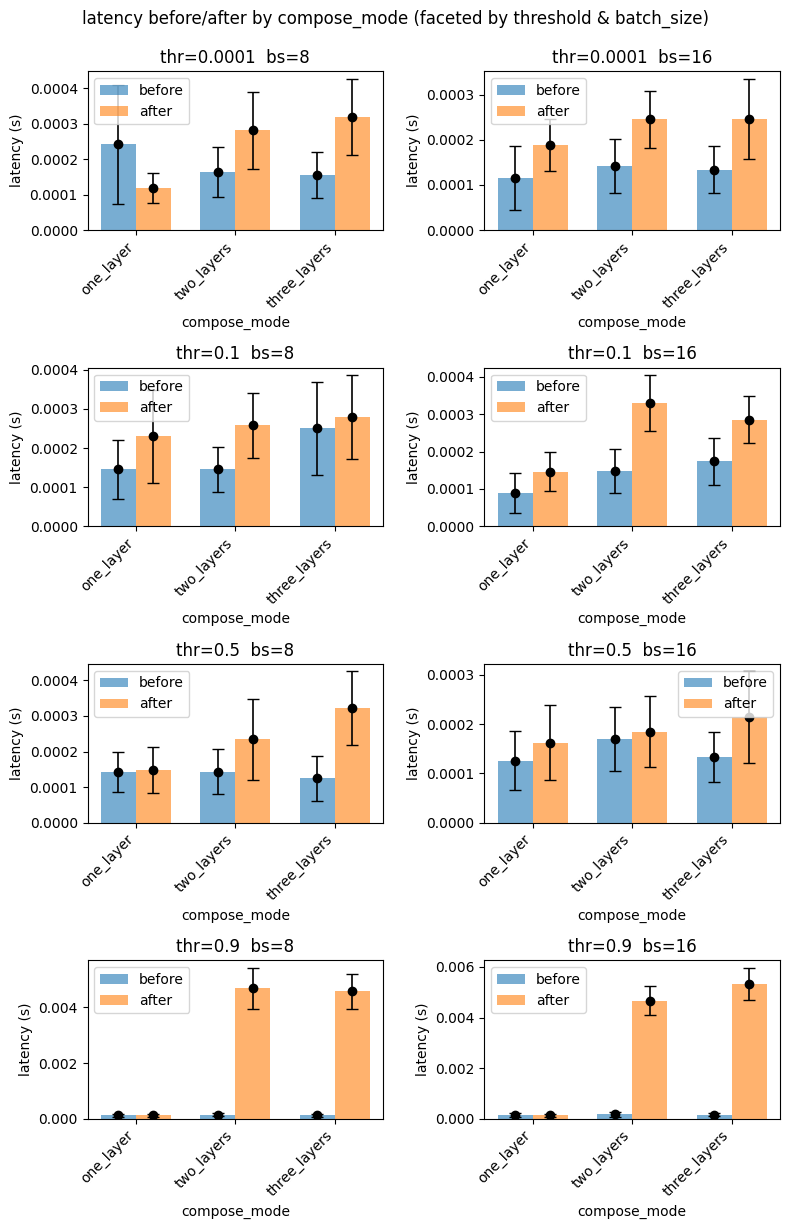

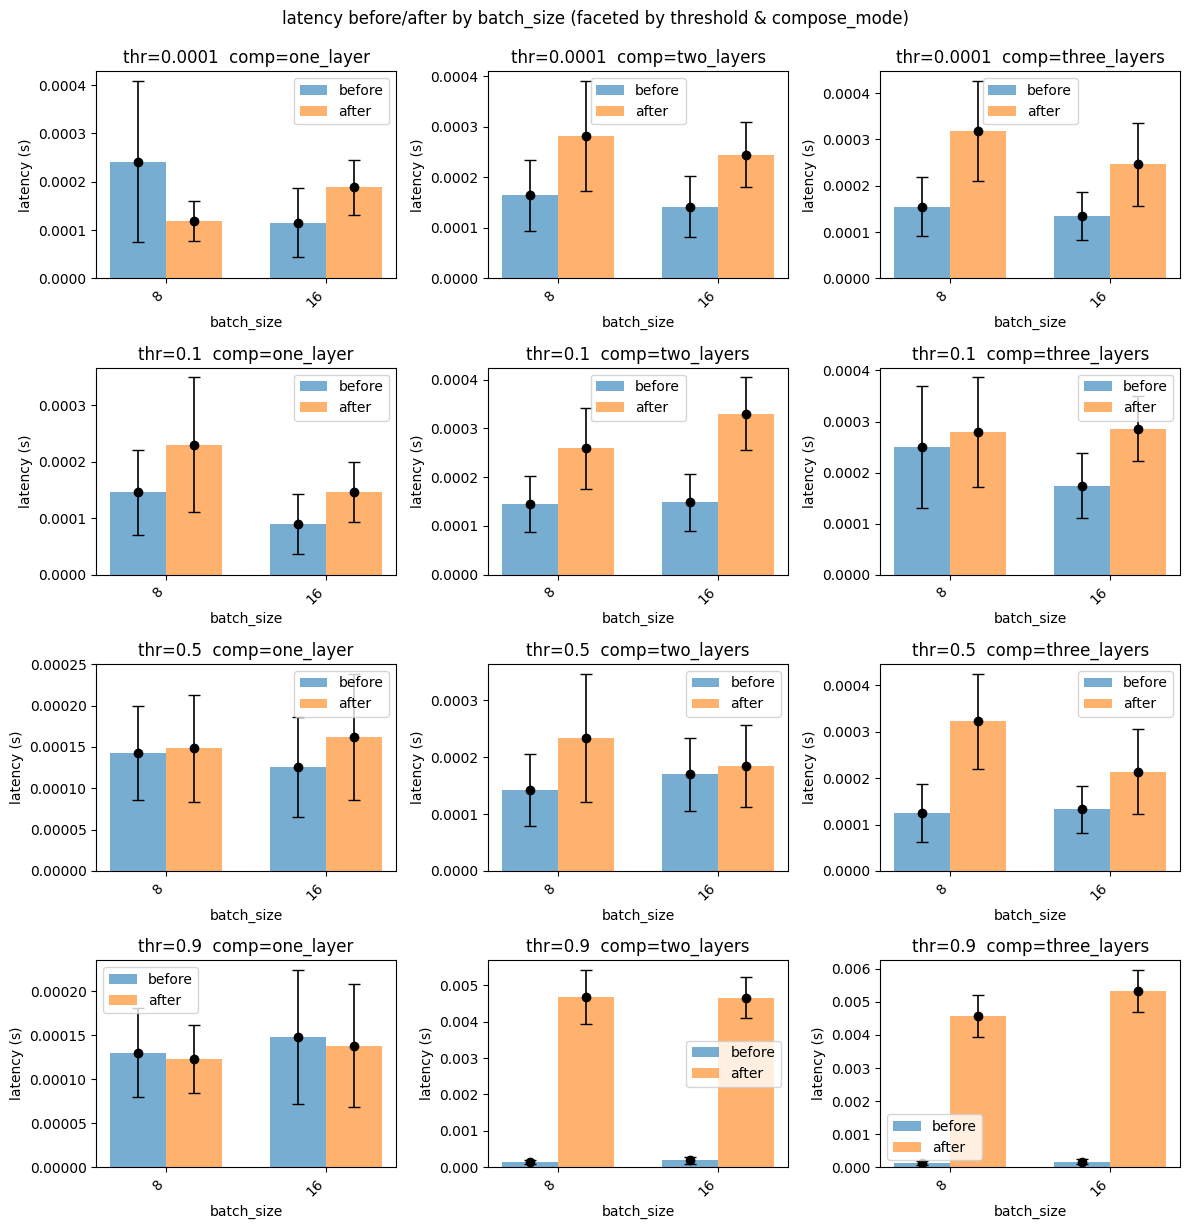

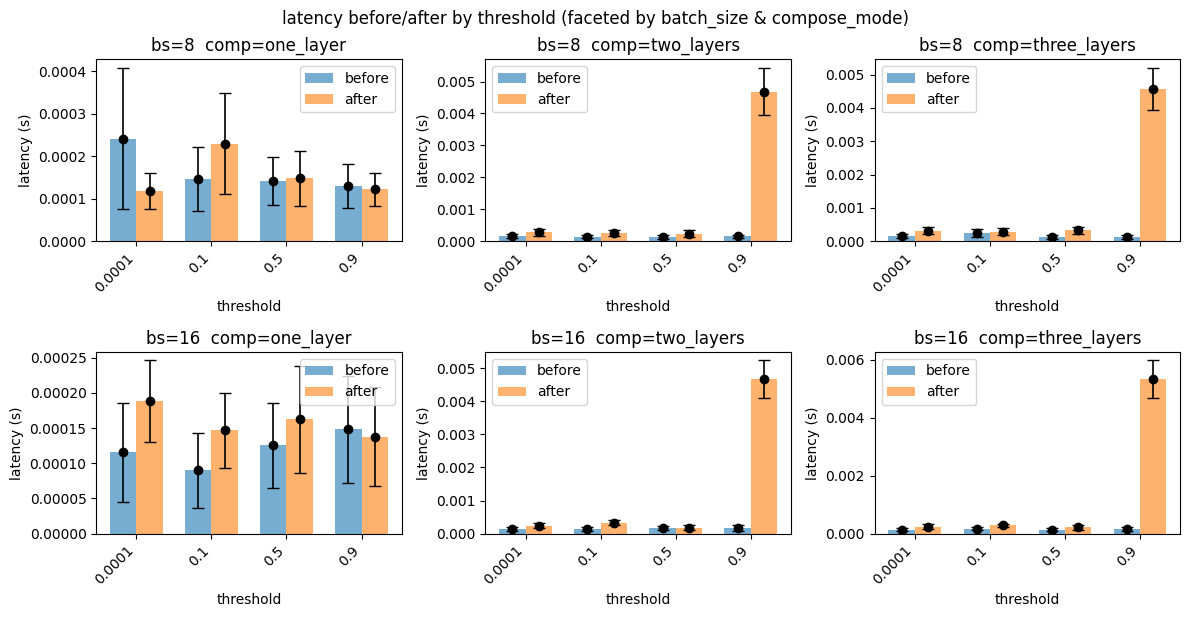

In [7]:
plot_latency_paired_grouped_5(df)

In [8]:
#// ...existing code...
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_latency_paired_grouped_5_layerwise(df, target_characteristic_name="latency", layer_name=None, layer_params=None):
    """
    Версия для layerwise-таблиц с фильтром по конкретному слою.
    Если указаны layer_name и/или layer_params, перед построением графиков
    будет выбран только этот слой ( фильтр по before_module_name и before_module_params ).
    Остальная логика как раньше: агрегация по модулям и построение трёх фасетов.

    Параметры:
      - df: DataFrame с layerwise-данными
      - target_characteristic_name: 'latency' или 'throughput' и т.д.
      - layer_name: строка (точное совпадение) для before_module_name
      - layer_params: числовое значение для before_module_params (точное совпадение)
    """
    df2 = df.copy()
    df2["threshold"] = pd.to_numeric(df2.get("threshold"), errors="coerce")
    # фильтр по слою (если задан)
    if layer_name is not None or layer_params is not None:
        mask = pd.Series([True] * len(df2), index=df2.index)
        if layer_name is not None:
            mask = mask & (df2.get("before_module_name").astype(str) == str(layer_name))
        if layer_params is not None:
            # попробуем привести колонку к числу для сравнения, если это возможно
            lp = float(layer_params)
            mask = mask & (pd.to_numeric(df2.get("before_module_params"), errors="coerce") == lp)
        df2 = df2[mask].copy()
    # print(df2)

    if df2.empty:
        print("Нет валидных данных после фильтрации по слою.")
        return

    def _agg_by_modules_and_labels(subset, group_col, labels):
        bm_means = []
        bm_stds = []
        am_means = []
        am_stds = []

        for lbl in labels:
            s = subset[subset[group_col] == lbl]
            #print(s)

            grp = s.groupby(["before_module_name", "before_module_params"], dropna=False)
            mod_before = grp[[f"before_{target_characteristic_name}_mean s", f"before_{target_characteristic_name}_std s"]].apply(lambda x: x.mean() if x.notna().any().any() else np.nan).dropna()
            mod_after  = grp[[f"after_{target_characteristic_name}_mean s", f"after_{target_characteristic_name}_std s"]].apply(lambda x: x.mean() if x.notna().any().any() else np.nan).dropna()
            
            #print(mod_before["before_latency_std s"])
            #print(mod_before)
            #print("---------------")
            bm_means.append(mod_before[f"before_{target_characteristic_name}_mean s"].mean())
            #bm_stds.append(mod_before.std(ddof=0))
            bm_stds.append(mod_before[f"before_{target_characteristic_name}_std s"].mean())

            am_means.append(mod_after[f"after_{target_characteristic_name}_mean s"].mean())
            am_stds.append(mod_after[f"after_{target_characteristic_name}_std s"].mean())
            #am_stds.append(mod_after.std(ddof=0))

        return bm_means, bm_stds, am_means, am_stds

    def _paired_bars(ax, labels, before_mean, before_std, after_mean, after_std, xlabel=None, ylabel=f"{target_characteristic_name} (s)"):
        x = np.arange(len(labels))
        width = 0.35
        before_mean = np.nan_to_num(np.array(before_mean, dtype=float), nan=0.0)
        after_mean = np.nan_to_num(np.array(after_mean, dtype=float), nan=0.0)
        before_std = np.nan_to_num(np.array(before_std, dtype=float), nan=0.0)
        after_std = np.nan_to_num(np.array(after_std, dtype=float), nan=0.0)

        ax.bar(x - width/2, before_mean, width, label="before", color="C0", alpha=0.6)
        ax.bar(x + width/2, after_mean, width, label="after", color="C1", alpha=0.6)
        ax.errorbar(x - width/2, before_mean, yerr=before_std, fmt='o', color='black', capsize=4, elinewidth=1.2)
        ax.errorbar(x + width/2, after_mean, yerr=after_std, fmt='o', color='black', capsize=4, elinewidth=1.2)
        ax.set_xticks(x)
        ax.set_xticklabels(labels, rotation=45, ha="right")
        if xlabel: ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.legend()

    comp_vals = ["one_layer", "two_layers", "three_layers"]
    # 1) compose_mode dependence: facet by threshold (rows) and batch_size (cols)
    thr_vals = sorted(df2["threshold"].dropna().unique())
    bs_vals = sorted(df2["batch_size"].dropna().unique())
    nrows, ncols = max(1, len(thr_vals)), max(1, len(bs_vals))
    fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 3*nrows), squeeze=False)
    for i, thr in enumerate(thr_vals):
        for j, bs in enumerate(bs_vals):
            ax = axes[i][j]
            subset = df2[(df2["threshold"] == thr) & (df2["batch_size"] == bs)]
            if subset.empty:
                ax.text(0.5, 0.5, "no data", ha="center", va="center")
                ax.set_xticks([]); ax.set_yticks([])
                ax.set_title(f"thr={thr} bs={bs}")
                continue
            labels = comp_vals
            bm, bs_std, am, a_std = _agg_by_modules_and_labels(subset, "compose_mode", labels)
            _paired_bars(ax, labels, bm, bs_std, am, a_std, xlabel="compose_mode", ylabel=target_characteristic_name)
            ax.set_title(f"thr={thr}  bs={bs}")
    plt.tight_layout()
    plt.suptitle(f"{target_characteristic_name} before/after by compose_mode (faceted by threshold & batch_size) — layer filter: {layer_name},{layer_params}", y=1.02)
    plt.show()

    # 2) batch_size dependence: facet by threshold (rows) and compose_mode (cols), x=batch_size
    thr_vals = sorted(df2["threshold"].dropna().unique())

    nrows, ncols = max(1, len(thr_vals)), max(1, len(comp_vals))
    fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 3*nrows), squeeze=False)
    for i, thr in enumerate(thr_vals):
        for j, comp in enumerate(comp_vals):
            ax = axes[i][j]
            subset = df2[(df2["threshold"] == thr) & (df2["compose_mode"].astype(str) == comp)]
            if subset.empty:
                ax.text(0.5, 0.5, "no data", ha="center", va="center")
                ax.set_xticks([]); ax.set_yticks([])
                ax.set_title(f"thr={thr} comp={comp}")
                continue
            labels = sorted(subset["batch_size"].unique(), key=lambda x: float(x))
            bm, bs_std, am, a_std = _agg_by_modules_and_labels(subset, "batch_size", labels)
            _paired_bars(ax, labels, bm, bs_std, am, a_std, xlabel="batch_size", ylabel=target_characteristic_name)
            ax.set_title(f"thr={thr}  comp={comp}")
    plt.tight_layout()
    plt.suptitle(f"{target_characteristic_name} before/after by batch_size (faceted by threshold & compose_mode) — layer filter: {layer_name},{layer_params}", y=1.02)
    plt.show()

    # 3) threshold dependence: facet by batch_size (rows) and compose_mode (cols), x=threshold
    bs_vals = sorted(df2["batch_size"].dropna().unique())
    thr_vals_sorted = sorted(df2["threshold"].dropna().unique())
    nrows, ncols = max(1, len(bs_vals)), max(1, len(comp_vals))
    fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 3*nrows), squeeze=False)
    for i, bs in enumerate(bs_vals):
        for j, comp in enumerate(comp_vals):
            ax = axes[i][j]
            subset = df2[(df2["batch_size"] == bs) & (df2["compose_mode"].astype(str) == comp)]
            if subset.empty:
                ax.text(0.5, 0.5, "no data", ha="center", va="center")
                ax.set_xticks([]); ax.set_yticks([])
                ax.set_title(f"bs={bs} comp={comp}")
                continue
            labels = subset["threshold"].dropna().unique()
            if labels is None:
                ax.text(0.5, 0.5, "no data", ha="center", va="center")
                continue
            bm, bs_std, am, a_std = _agg_by_modules_and_labels(subset, "threshold", labels)
            _paired_bars(ax, labels, bm, bs_std, am, a_std, xlabel="threshold", ylabel=target_characteristic_name)
            ax.set_title(f"bs={bs}  comp={comp}")
    plt.tight_layout()
    plt.suptitle(f"{target_characteristic_name} before/after by threshold (faceted by batch_size & compose_mode) — layer filter: {layer_name},{layer_params}", y=1.02)
    plt.show()

# ...existing code...

In [9]:
print(df["before_module_name"].unique())
print(df["before_module_params"].unique())
print(df[df["before_module_name"] == "Linear"]["before_module_params"].unique())

['Conv2d' 'Linear']
[   9408   36864   73728  147456    8192  294912  589824   32768 1179648
 2359296  131072    5130]
[5130]


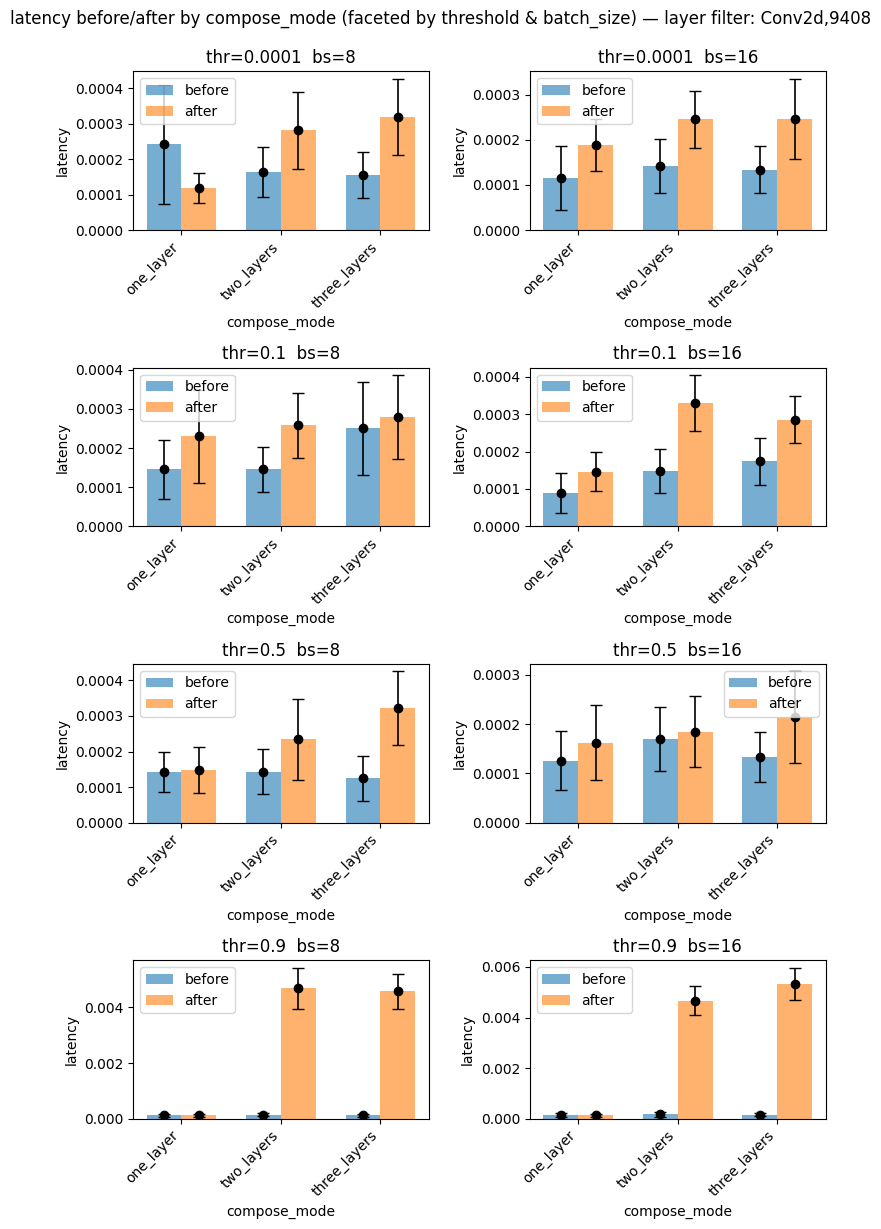

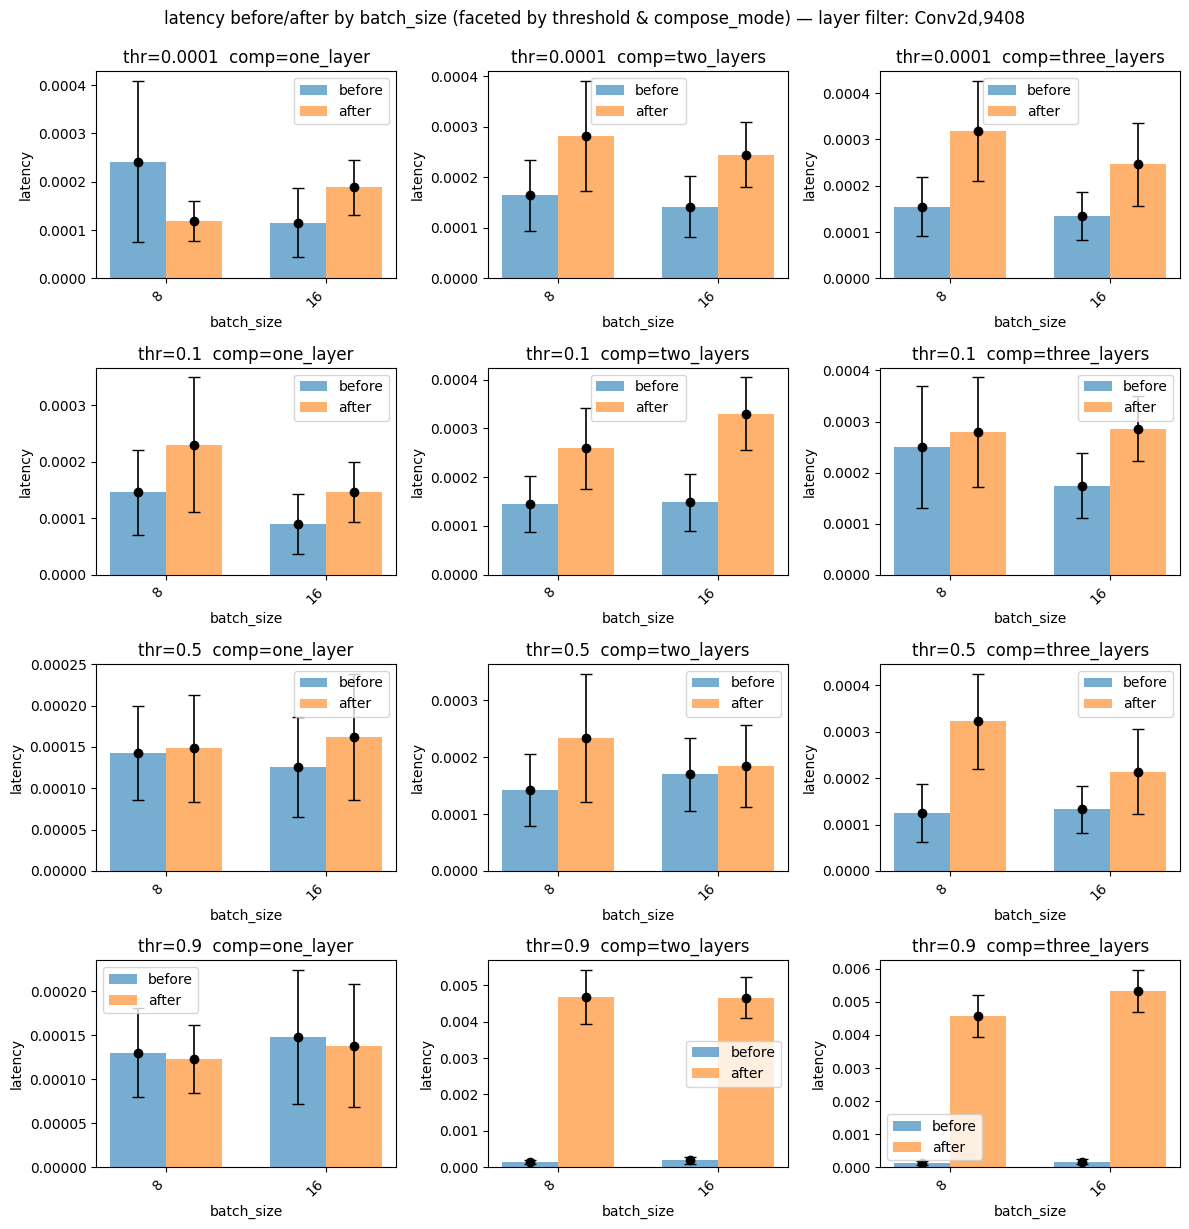

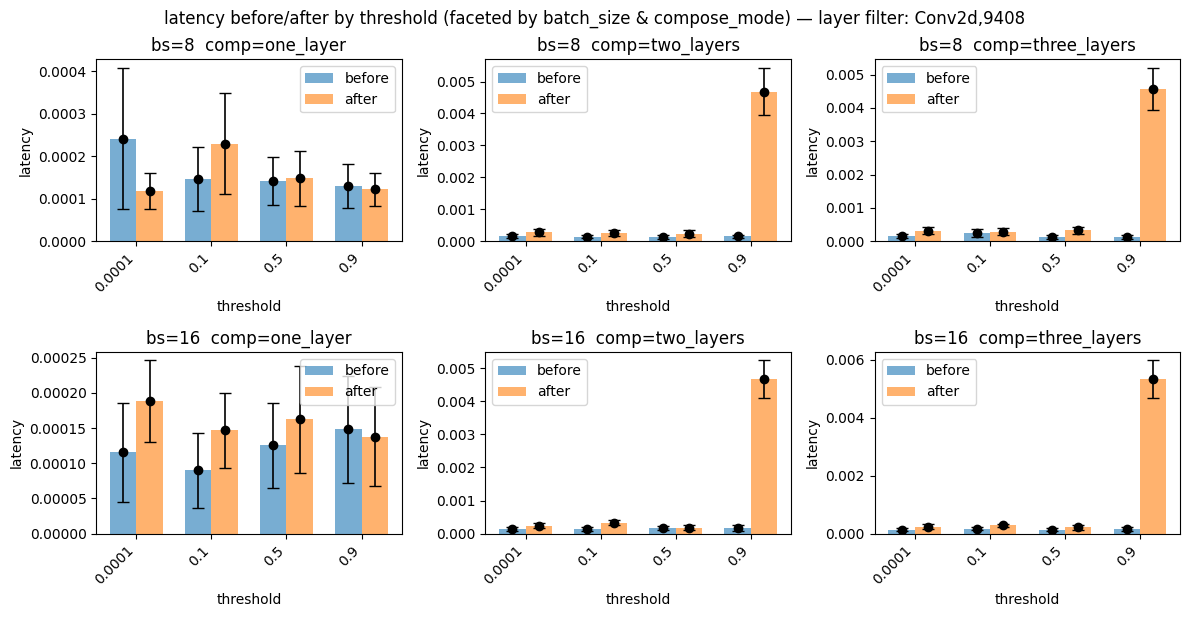

In [10]:
#df[df["before_module_params"] == 9408]
plot_latency_paired_grouped_5_layerwise(df, layer_name="Conv2d", layer_params=9408)

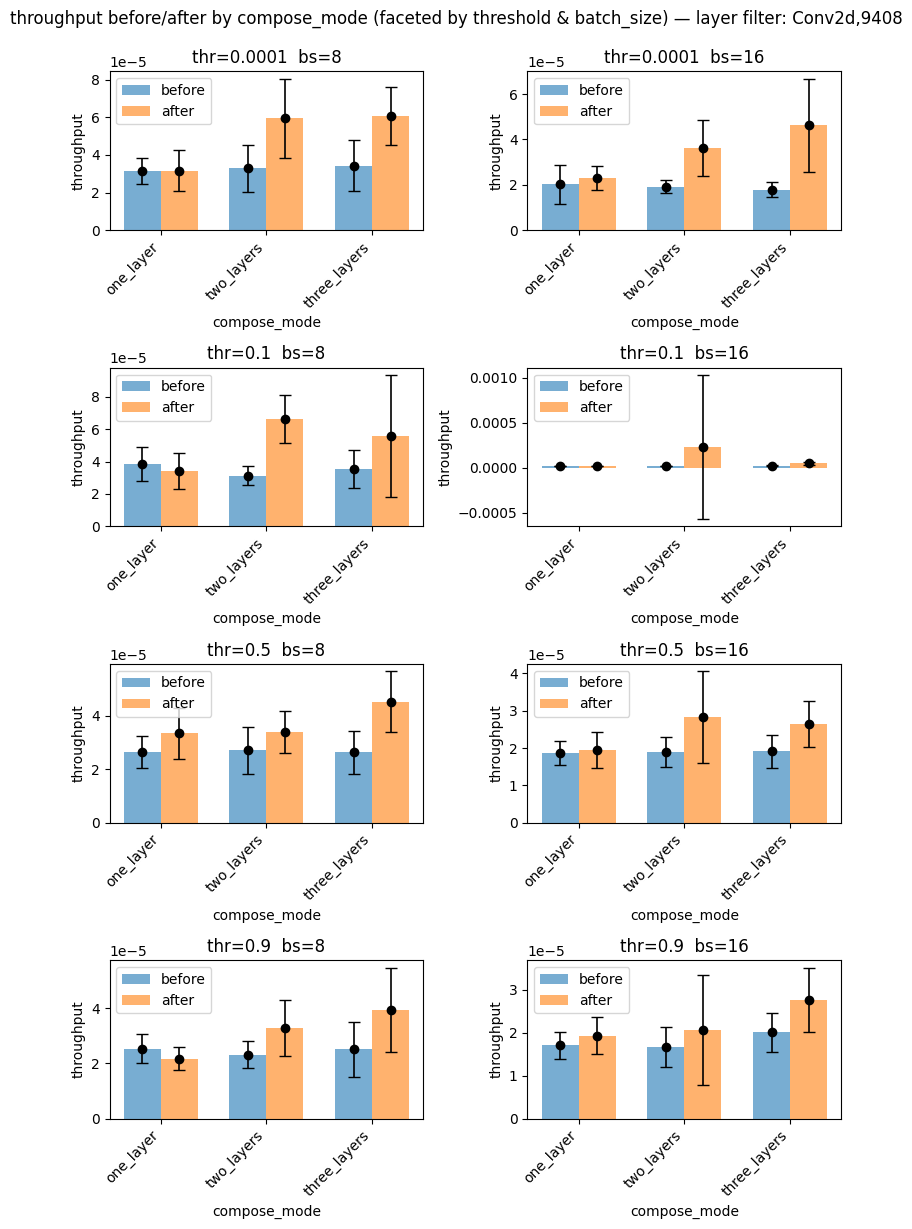

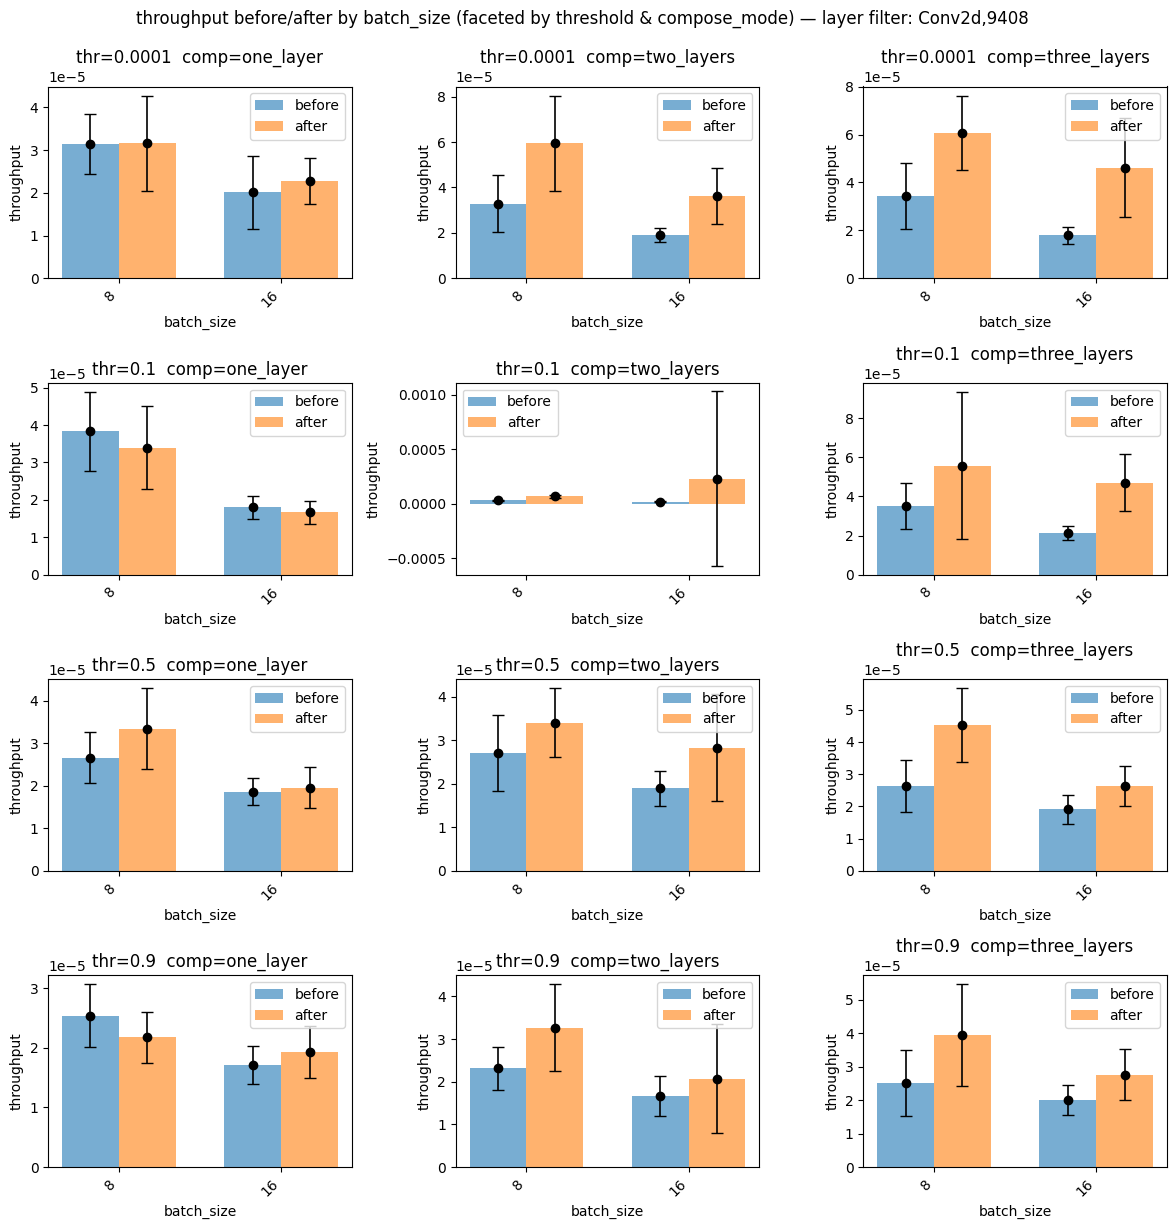

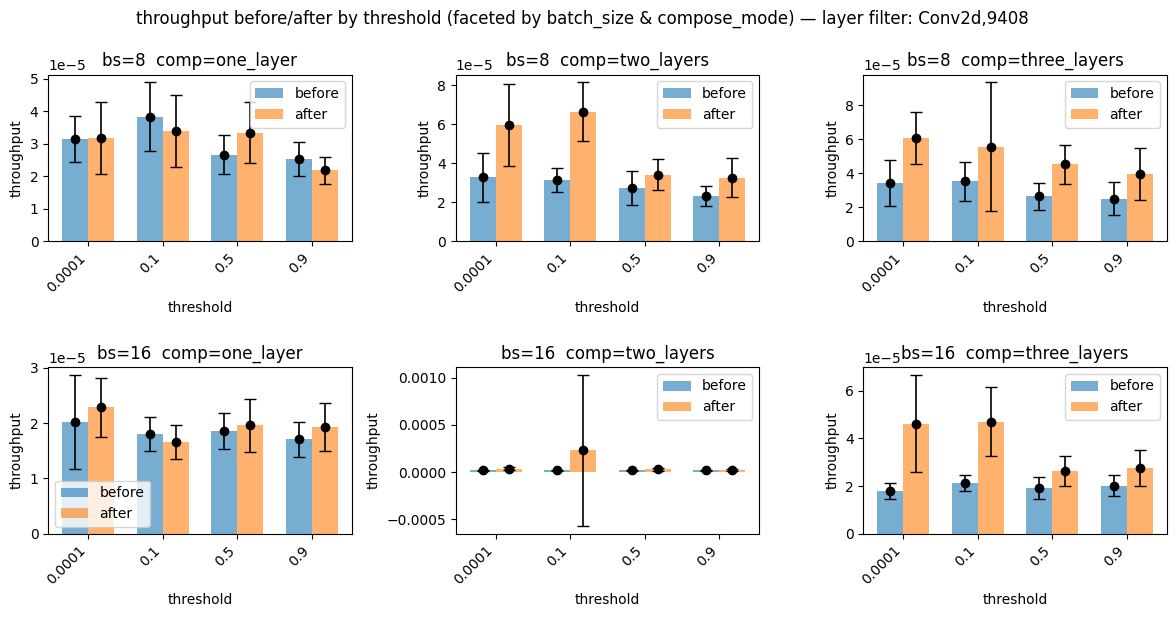

In [11]:
plot_latency_paired_grouped_5_layerwise(df, target_characteristic_name="throughput", layer_name="Conv2d", layer_params=9408)

Видно, что в среднем постоянно происходит увеличение длительности. Ни разу не происходит ускорение. Даже на больших thresholds получаем замедление операций для two_layers и three_layers.
При этом не сильно замедлиться можем только на one_layer.

In [26]:
from scipy import stats
df_typical = df[(df["threshold"] == 0.1) & (df["compose_mode"] == "two_layers") & (df["batch_size"] == 16)]
df_typical["abs_througpohut_increase"] = (df_typical["after_throughput_mean s"] - df_typical["before_throughput_mean s"])
df_typical["relative_througpohut_increase"] = df_typical["abs_througpohut_increase"] / df_typical["before_throughput_mean s"]
df_typical["relative_througpohut_increase"]


336    11.434328
337     0.498113
338     0.038591
339    -0.050000
340    -0.211014
341     0.008266
342     0.114427
343     0.817783
344    -0.148033
345     0.073873
346     0.224150
347     0.146030
348     0.437956
349    -0.057633
350    -0.093096
351     0.110316
352     0.094864
353     0.631844
354     0.083216
355     0.103811
356     0.343349
Name: relative_througpohut_increase, dtype: float64

In [27]:
df_typical = df_typical[(np.abs(stats.zscore(df_typical["relative_througpohut_increase"])) < 3)]
df_typical

,batch_size,threshold,low_rank_mode,compose_mode,device,before_module_name,before_module_params,before_module_shape,before_latency_mean s,before_latency_std s,...,after_latency_mean s,after_latency_std s,after_throughput_mean s,after_throughput_std s,after_model_size_mb,after_S_shape,after_Vh_shape,after_U_shape,abs_througpohut_increase,relative_througpohut_increase
337,16,0.1,quantile,two_layers,cpu,Conv2d,36864,"[64, 64, 3, 3]",0.000235,0.000037,...,0.000447,0.000069,0.000235,0.000018,0.146,0,"[60, 64, 3, 3]","[64, 60, 1, 1]",7.823094e-05,0.498113
338,16,0.1,quantile,two_layers,cpu,Conv2d,36864,"[64, 64, 3, 3]",0.000323,0.000065,...,0.000546,0.000130,0.000178,0.000018,0.146,0,"[60, 64, 3, 3]","[64, 60, 1, 1]",6.610313e-06,0.038591
339,16,0.1,quantile,two_layers,cpu,Conv2d,36864,"[64, 64, 3, 3]",0.000455,0.000123,...,0.000439,0.000081,0.000171,0.000018,0.146,0,"[60, 64, 3, 3]","[64, 60, 1, 1]",-9.015000e-06,-0.050000
340,16,0.1,quantile,two_layers,cpu,Conv2d,36864,"[64, 64, 3, 3]",0.000385,0.000126,...,0.000627,0.000144,0.000196,0.000025,0.146,0,"[60, 64, 3, 3]","[64, 60, 1, 1]",-5.234094e-05,-0.211014
341,16,0.1,quantile,two_layers,cpu,Conv2d,73728,"[128, 64, 3, 3]",0.000287,0.000079,...,0.000337,0.000134,0.000105,0.000015,0.312,0,"[116, 64, 3, 3]","[128, 116, 1, 1]",8.646875e-07,0.008266
342,16,0.1,quantile,two_layers,cpu,Conv2d,147456,"[128, 128, 3, 3]",0.000603,0.000053,...,0.001073,0.000122,0.000818,0.000068,0.566,0,"[116, 128, 3, 3]","[128, 116, 1, 1]",8.399312e-05,0.114427
343,16,0.1,quantile,two_layers,cpu,Conv2d,8192,"[128, 64, 1, 1]",0.000175,0.000064,...,0.000267,0.000130,0.000067,0.000017,0.044,0,"[60, 64, 1, 1]","[128, 60, 1, 1]",3.025438e-05,0.817783
344,16,0.1,quantile,two_layers,cpu,Conv2d,147456,"[128, 128, 3, 3]",0.000748,0.000098,...,0.001441,0.000502,0.000659,0.000027,0.566,0,"[116, 128, 3, 3]","[128, 116, 1, 1]",-1.144444e-04,-0.148033
345,16,0.1,quantile,two_layers,cpu,Conv2d,147456,"[128, 128, 3, 3]",0.000777,0.000078,...,0.000988,0.000114,0.000737,0.000066,0.566,0,"[116, 128, 3, 3]","[128, 116, 1, 1]",5.072531e-05,0.073873
346,16,0.1,quantile,two_layers,cpu,Conv2d,294912,"[256, 128, 3, 3]",0.000456,0.000092,...,0.000710,0.000082,0.000441,0.000045,1.246,0,"[232, 128, 3, 3]","[256, 232, 1, 1]",8.083281e-05,0.224150


In [28]:
print(df_typical["relative_througpohut_increase"].mean())
print(df_typical["relative_througpohut_increase"].median())

0.15834053549892663
0.09933728053702268


Итого: на процессоре для обычных значений batch = 16, compose=two_layers, threshold=0.1 замедление составляет около 15%.

In [49]:
from scipy import stats
df_typical_three = df[(df["threshold"] == 0.1) & (df["compose_mode"] == "three_layers") & (df["batch_size"] == 16)]
df_typical_three["abs_througpohut_increase"] = df_typical_three["after_throughput_mean s"] - df_typical_three["before_throughput_mean s"]
df_typical_three["relative_througpohut_increase"] = df_typical_three["abs_througpohut_increase"] / df_typical_three["before_throughput_mean s"]
df_typical_three["relative_througpohut_increase"]


357    1.203029
358    0.474325
359    0.361561
360    0.326279
361    0.259489
362    0.345964
363    0.292784
364    1.684651
365    0.060716
366    0.083455
367    0.225696
368    0.102397
369    0.548890
370   -0.081492
371   -0.100714
372    0.184672
373    0.203937
374    0.470443
375    0.137215
376    0.159916
377    0.947215
Name: relative_througpohut_increase, dtype: float64

In [50]:
df_typical_three = df_typical_three[(np.abs(stats.zscore(df_typical_three["relative_througpohut_increase"])) < 3)]
df_typical_three

,batch_size,threshold,low_rank_mode,compose_mode,device,before_module_name,before_module_params,before_module_shape,before_latency_mean s,before_latency_std s,...,after_latency_mean s,after_latency_std s,after_throughput_mean s,after_throughput_std s,after_model_size_mb,after_S_shape,after_Vh_shape,after_U_shape,abs_througpohut_increase,relative_througpohut_increase
357,16,0.1,quantile,three_layers,cpu,Conv2d,9408,"[64, 3, 7, 7]",0.000175,0.000063,...,0.000286,0.000064,0.000047,0.000014,0.049,"[60, 1, 1]","[60, 3, 7, 7]","[64, 60, 1, 1]",0.000026,1.203029
358,16,0.1,quantile,three_layers,cpu,Conv2d,36864,"[64, 64, 3, 3]",0.000213,0.000045,...,0.000527,0.000059,0.000229,0.000009,0.147,"[60, 1, 1]","[60, 64, 3, 3]","[64, 60, 1, 1]",0.000074,0.474325
359,16,0.1,quantile,three_layers,cpu,Conv2d,36864,"[64, 64, 3, 3]",0.000303,0.000076,...,0.000465,0.000109,0.000216,0.000012,0.147,"[60, 1, 1]","[60, 64, 3, 3]","[64, 60, 1, 1]",0.000057,0.361561
360,16,0.1,quantile,three_layers,cpu,Conv2d,36864,"[64, 64, 3, 3]",0.000263,0.000072,...,0.000536,0.000104,0.000224,0.000010,0.147,"[60, 1, 1]","[60, 64, 3, 3]","[64, 60, 1, 1]",0.000055,0.326279
361,16,0.1,quantile,three_layers,cpu,Conv2d,36864,"[64, 64, 3, 3]",0.000258,0.000050,...,0.000449,0.000131,0.000209,0.000018,0.147,"[60, 1, 1]","[60, 64, 3, 3]","[64, 60, 1, 1]",0.000043,0.259489
362,16,0.1,quantile,three_layers,cpu,Conv2d,73728,"[128, 64, 3, 3]",0.000195,0.000047,...,0.000351,0.000070,0.000107,0.000011,0.312,"[116, 1, 1]","[116, 64, 3, 3]","[128, 116, 1, 1]",0.000027,0.345964
363,16,0.1,quantile,three_layers,cpu,Conv2d,147456,"[128, 128, 3, 3]",0.000640,0.000102,...,0.001077,0.000128,0.000852,0.000098,0.567,"[116, 1, 1]","[116, 128, 3, 3]","[128, 116, 1, 1]",0.000193,0.292784
365,16,0.1,quantile,three_layers,cpu,Conv2d,147456,"[128, 128, 3, 3]",0.000595,0.000067,...,0.001082,0.000127,0.000802,0.000109,0.567,"[116, 1, 1]","[116, 128, 3, 3]","[128, 116, 1, 1]",0.000046,0.060716
366,16,0.1,quantile,three_layers,cpu,Conv2d,147456,"[128, 128, 3, 3]",0.000669,0.000110,...,0.001080,0.000146,0.000781,0.000082,0.567,"[116, 1, 1]","[116, 128, 3, 3]","[128, 116, 1, 1]",0.000060,0.083455
367,16,0.1,quantile,three_layers,cpu,Conv2d,294912,"[256, 128, 3, 3]",0.000434,0.000096,...,0.000764,0.000084,0.000457,0.000031,1.247,"[232, 1, 1]","[232, 128, 3, 3]","[256, 232, 1, 1]",0.000084,0.225696


In [51]:
print(df_typical_three["relative_througpohut_increase"].mean())
print(df_typical_three["relative_througpohut_increase"].median())

0.3102887952280688
0.24259271014460793


Для 3 слойного разложения и подавно замедление около 31%.

In [59]:
def plot_time_increase_vs_module_params(df_typical, compose_mode, rel_or_abs="relative", ):
    df_xy = df_typical[["before_module_params", f"{rel_or_abs}_througpohut_increase"]].sort_values("before_module_params")
    df_xy = df_xy.groupby("before_module_params").mean()

    x = df_xy.index.values
    y = df_xy[[f"{rel_or_abs}_througpohut_increase"]]


    fig = plt.figure()
    plt.title(f"For compose_mode={compose_mode}, threshold=0.1, bs=16")
    plt.xlabel("Module params of different modules (sorted)")
    plt.ylabel(f"{rel_or_abs} throughput time increase (mean)")
    plt.xticks(df_xy.index.values)
    #plt.yticks(np.arange(0, 1, 0.1))
    fig.axes[0].set_xticklabels(df_xy.index.values, rotation=90, ha="right")
    plt.tight_layout()
    plt.plot(x, y)
    plt.grid(True, linestyle=":", alpha=0.5)
    plt.show()

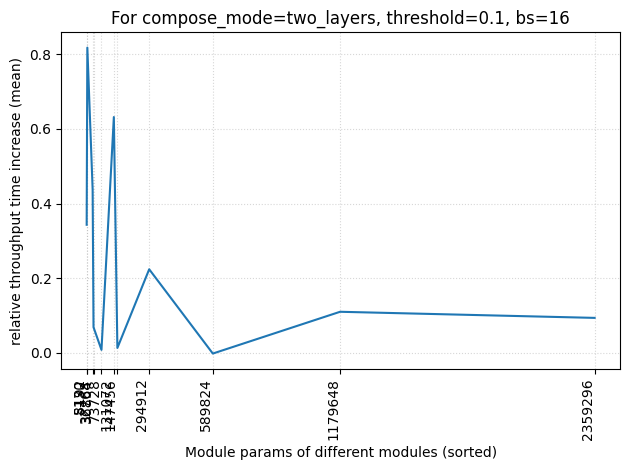

In [60]:
plot_time_increase_vs_module_params(df_typical, "two_layers", "relative")

Как предполагалось теоретически, чем меньше модуль, тем сильнее влияет разложение на его throughput

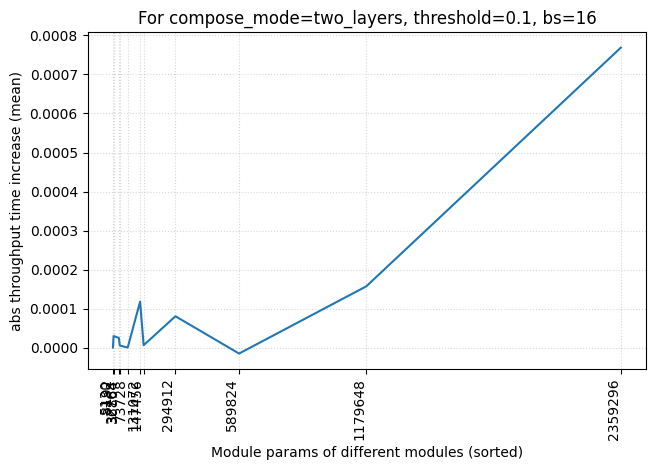

In [61]:
plot_time_increase_vs_module_params(df_typical, "two_layers", "abs")

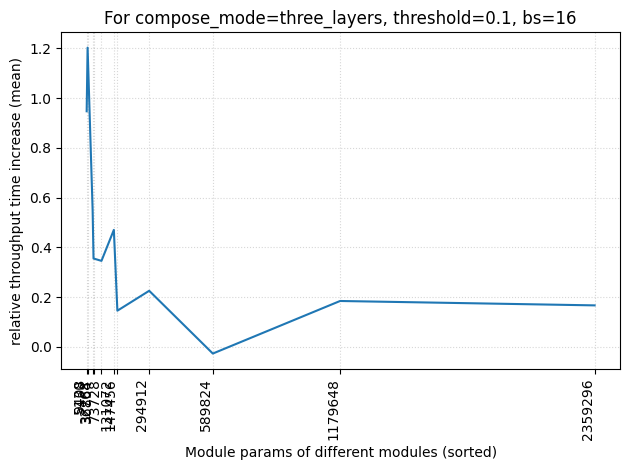

In [62]:
plot_time_increase_vs_module_params(df_typical_three, "three_layers", "relative")

Аналогично: для маленьких свёрток влияние разложения сильнее, так как относительная вычислительная сложность самой операции становится сопоставима с накладными расходами на переключение.

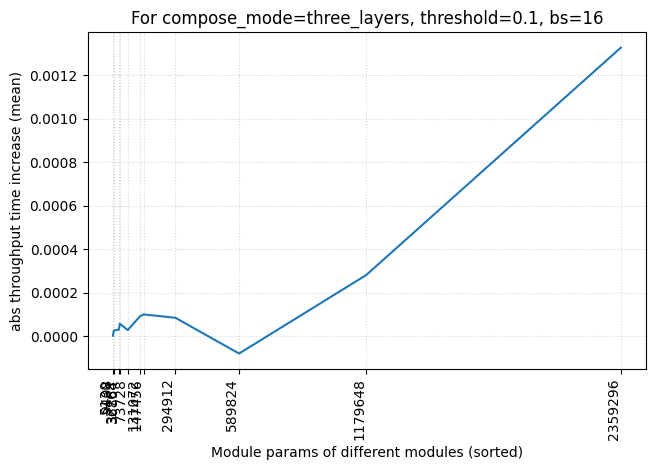

In [63]:
plot_time_increase_vs_module_params(df_typical_three, "three_layers", "abs")

In [64]:
#величины для опоры
print("Throughput (s / sample) порядка ", df["after_throughput_mean s"].median())

Throughput (s / sample) порядка  0.0002889084375965


Но даже и для больших свёрток мы наблюдаем, что замедление есть. Относительно оно около 10%, но это всё ещё
какие-то милисекунды.